b_array:  [1. 1.]
c_array:  [1. 1.]
b_array:  [0.98267949 1.        ]
c_array:  [1.         0.98267949]
b_array:  [0.979996 1.      ]
c_array:  [1.       0.979996]
b_array:  [0.97089436 1.        ]
c_array:  [1.         0.97044418]
b_array:  [0.92558609 1.        ]
c_array:  [1.         0.92302519]
b_array:  [0.9171913 1.       ]
c_array:  [1.        0.9146917]
b_array:  [0.9080032 1.       ]
c_array:  [1.         0.90459474]
b_array:  [0.9092017 1.       ]
c_array:  [1.         0.90481933]
b_array:  [0.82256609 1.        ]
c_array:  [1.         0.80956344]
b_array:  [0.79869418 1.        ]
c_array:  [1.         0.77321719]
b_array:  [0.61096155 1.        ]
c_array:  [1.         0.58290661]
b_array:  [0.46287089 1.        ]
c_array:  [1.         0.53121907]
b_array:  [0.42479091 1.        ]
c_array:  [1.         0.49950333]
b_array:  [0.62399028 1.        ]
c_array:  [1.         0.53451945]
b_array:  [0.58764867 1.        ]
c_array:  [1.         0.48054525]
b_array:  [0.57470526 1.    

/var/folders/2h/xz8d592j62n7f363_sbw7ly00000gn/T/ipykernel_19751/928954295.py:232: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10')  # choose 'tab10' or 'tab20'


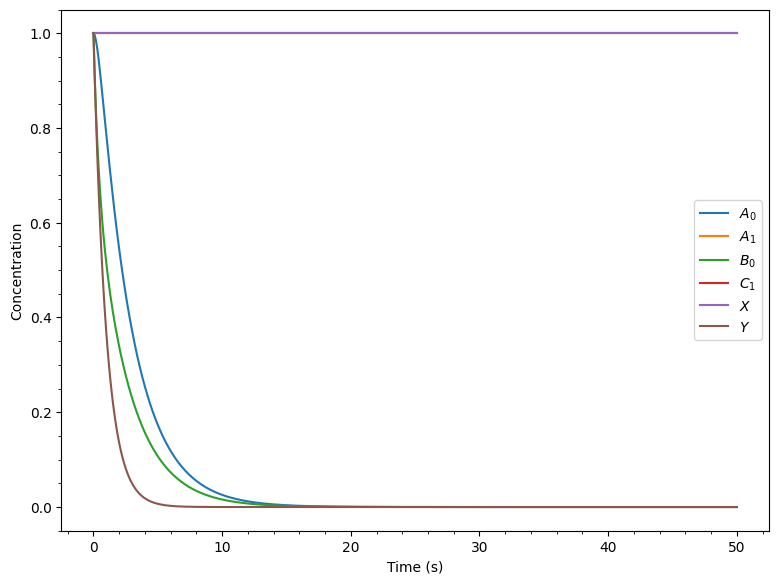

In [309]:
import numpy as np
import sympy as sp
from typing import List, Tuple, Dict, Any, Set
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
class all_parameter_generation:
    """
    Generate state transitions and random parameters (a, b, c, enzyme) for an n-site phosphorylation model.

    Args:
        n: number of sites (int)
        distribution: distribution name ("gamma" supported)
        params: parameters for the distribution (for gamma: [shape, scale])
        verbose: if True, prints transitions and matrices
    """
    def __init__(self, n: int, distribution: str = "gamma", params: List[float] = [1.0, 1.0],
                 verbose: bool = False):
        self.n = n
        self.num_states = 2 ** n
        self.distribution = distribution
        self.params = params
        self.verbose = verbose
        self.rng = np.random.default_rng()

    @staticmethod
    def padded_binary(i: int, n: int) -> str:
        return bin(i)[2:].zfill(n)

    @staticmethod
    def binary_string_to_array(string: str) -> np.ndarray:
        return np.array([int(i) for i in string], dtype=int)

    def calculate_valid_transitions(self) -> Tuple[List[List[Any]], List[List[Any]]]:
        """
        Returns:
            valid_E_reactions: list of [state_i_str, state_j_str, i, j, "E"]
            valid_F_reactions: list of [state_i_str, state_j_str, i, j, "F"]
        """
        all_states = [self.padded_binary(i, self.n) for i in range(self.num_states)]

        valid_difference_vectors: Set[Tuple[int, ...]] = set()
        valid_E_reactions: List[List[Any]] = []
        valid_F_reactions: List[List[Any]] = []

        for i in range(self.num_states):
            arr_i = self.binary_string_to_array(all_states[i])
            for j in range(self.num_states):
                if i == j:
                    continue
                arr_j = self.binary_string_to_array(all_states[j])
                diff = arr_j - arr_i
                if np.sum(np.abs(diff)) == 1:
                    # +1 -> phosphorylation (E), -1 -> dephosphorylation (F)
                    element = "E" if np.any(diff == 1) else "F"
                    if element == "E":
                        if self.verbose:
                            print(f"{all_states[i]} --> {all_states[j]} (E), {i}, {j}")
                        valid_E_reactions.append([all_states[i], all_states[j], i, j, element])
                    else:
                        if self.verbose:
                            print(f"{all_states[i]} --> {all_states[j]} (F), {i}, {j}")
                        valid_F_reactions.append([all_states[i], all_states[j], i, j, element])
                    valid_difference_vectors.add(tuple(diff))

        return valid_E_reactions, valid_F_reactions

    def alpha_parameter_generation(self) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray,
                                            Dict[int, List[int]], Dict[int, List[int]],
                                            Dict[int, List[int]], Dict[int, List[int]]]:
        
        valid_E_reactions, valid_F_reactions = self.calculate_valid_transitions()

        shape, scale = self.params
        # matrices are num_states x num_states

        alpha_out_matrix = np.zeros((self.num_states, self.num_states))
        alpha_in_matrix = np.zeros((self.num_states, self.num_states))

        alpha_out: Dict[int, List[int]] = {}
        alpha_in: Dict[int, List[int]] = {}
        for _, _, i, j, _ in valid_E_reactions:
            alpha_out.setdefault(i, []).append(j)
            alpha_in.setdefault(j, []).append(i)
            alpha_out_matrix[i, j] = self.rng.gamma(shape, scale)
            alpha_in_matrix[j, i] = self.rng.gamma(shape, scale)

        return alpha_out_matrix, alpha_in_matrix, alpha_out, alpha_in
        # return (c_E_out_matrix, c_F_out_matrix, c_E_in_matrix, c_F_in_matrix,
        #         cE_out, cF_out, cE_in, cF_in)

    def beta_parameter_generation(self) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray,
                                            Dict[int, List[int]], Dict[int, List[int]],
                                            Dict[int, List[int]], Dict[int, List[int]]]:
        
        valid_E_reactions, valid_F_reactions = self.calculate_valid_transitions()

        shape, scale = self.params

        beta_out_matrix = np.zeros((self.num_states, self.num_states))
        beta_in_matrix = np.zeros((self.num_states, self.num_states))

        beta_out: Dict[int, List[int]] = {}
        beta_in: Dict[int, List[int]] = {}
        for _, _, i, j, _ in valid_F_reactions:
            beta_out.setdefault(i, []).append(j)
            beta_in.setdefault(j, []).append(i)
            beta_out_matrix[i, j] = self.rng.gamma(shape, scale)
            beta_in_matrix[j, i] = self.rng.gamma(shape, scale)

        return beta_out_matrix, beta_in_matrix, beta_out, beta_in

    def k_parameter_generation(self) -> Tuple[np.ndarray, np.ndarray]:
        if self.distribution != "gamma":
            raise NotImplementedError("Only 'gamma' distribution implemented for a_parameter_generation")
        shape, scale = self.params
        k_positive_rates = self.rng.gamma(shape, scale, self.num_states)
        k_negative_rates = self.rng.gamma(shape, scale, self.num_states)
        return k_positive_rates, k_negative_rates

    def p_parameter_generation(self) -> Tuple[np.ndarray, np.ndarray]:
        
        if self.distribution != "gamma":
            raise NotImplementedError("Only 'gamma' distribution implemented for b_parameter_generation")
        shape, scale = self.params
        p_positive_rates = self.rng.gamma(shape, scale, self.num_states)
        p_negative_rates = self.rng.gamma(shape, scale, self.num_states)
        return p_positive_rates, p_negative_rates


import numpy as np
from typing import List


def generate_phosphorylation_ODES(t, state_array, n, alpha_in_matrix, alpha_in, beta_in_matrix, beta_in, k_positive_rates, k_negative_rates, p_positive_rates, p_negative_rates):

    a_array = state_array[0: 2**n] # A = S
    b_array = state_array[2**n: 2 * 2**n]
    c_array = state_array[2 * 2**n: 3 * 2**n]
    print("b_array: ", b_array)
    print("c_array: ", c_array)
    x_array = state_array[-2] # X = E, kinase
    y_array = state_array[-1] # Y = F, phosphotase

    a_dot = np.zeros_like(a_array, dtype=float)
    b_dot = np.zeros_like(b_array, dtype=float)
    c_dot = np.zeros_like(c_array, dtype=float)

    for i in range(len(a_dot)):
        E_term = 0
        E_term += k_negative_rates[i] * b_array[i] - k_positive_rates[i] * x_array * a_array[i]
        if 0 <= i < len(range(len(a_dot))):
            a_dot[i] = k_negative_rates[i] * b_array[i] - k_positive_rates[i] * x_array * a_array[i]
        else:
            E_term += 0

        F_term = 0
        if 0 < i < len(range(len(a_dot))):
            F_term += p_negative_rates[i] * c_array[i] - p_positive_rates[i] * y_array * a_array[i]

        sum_cE = sum(alpha_in_matrix[k, i] * b_array[k] for k in alpha_in.get(i, [])) if i in alpha_in else 0
        sum_cF = sum(beta_in_matrix[k, i] * c_array[k] for k in beta_in.get(i, [])) if i in beta_in else 0

        a_dot[i] = E_term + F_term + sum_cE + sum_cF

    for i in range(0, len(b_dot) - 1):
        sum_b = np.sum(alpha_in_matrix[i, :])
        b_dot[i] = k_positive_rates[i] * x_array * a_array[i] - k_negative_rates[i] * b_array[i] - sum_b * b_array[i]

    for i in range(1, len(c_dot)):
        sum_c = np.sum(beta_in_matrix[i, :])
        c_dot[i] = p_positive_rates[i] * y_array * a_array[i] - p_negative_rates[i] * c_array[i] - sum_c * c_array[i]

    x_dot = sum(-k_positive_rates[j] * x_array * a_array[j] + (k_negative_rates[j] + np.sum(alpha_in_matrix[j, :])) * b_array[j] for j in range(len(b_array))); 
    y_dot = sum(-p_positive_rates[j] * y_array * a_array[j] + (p_negative_rates[j] + np.sum(beta_in_matrix[j, :])) * c_array[j] for j in range(len(c_array))); 

    # if (np.sum(a_dot) + np.sum(b_dot) + np.sum(c_dot)) <= 1e-5:
    #     print("Conservation of a is respected.")

    # if (np.sum(b_dot) + x_dot) <= 1e-5:
    #     print("Conservation of b is respected.")

    # if (np.sum(c_dot) + y_dot) <= 1e-5:
    #     print("Conservation of c is respected.")

    # print()
    # print("a_dot_array: ", a_dot)
    # print("b_dot_array: ", b_dot)
    # print("c_dot_array: ", c_dot)
    # print("x_dot_array: ", x_dot)
    # print("y_dot_array: ", y_dot)
    # print()

    
    final_state_array = np.concatenate((a_dot, b_dot, c_dot))
    return final_state_array

n = 1
gen = all_parameter_generation(n, distribution = "gamma", params=(1, 1), verbose=False)

alpha_out_matrix, alpha_in_matrix, alpha_out, alpha_in = gen.alpha_parameter_generation()
beta_out_matrix, beta_in_matrix, beta_out, beta_in = gen.beta_parameter_generation()

k_positive_rates, k_negative_rates = gen.k_parameter_generation()
p_positive_rates, p_negative_rates = gen.p_parameter_generation()
distribution_params = [1.0, 1.0]

######################
k_positive_rates_custom = [1, 1] # a_E
k_negative_rates_custom = [1, 1] # a_E
p_positive_rates_custom = [1, 1]   # b_E
p_negative_rates_custom = [1, 1]   # b_E
alpha_out_matrix_custom = np.array([[0, 1], [0, 0]])
alpha_out_custom = alpha_out 
beta_out_matrix_custom = np.array([[0, 0], [1, 0]])
beta_out_custom = beta_out 


######################
params = (n, alpha_out_matrix_custom, alpha_out_custom, beta_out_matrix_custom, beta_out_custom, k_positive_rates_custom, k_negative_rates_custom, p_positive_rates_custom, p_negative_rates_custom)

# params = (n, "gamma", 1, 1, alpha_out_matrix, alpha_in_matrix, alpha_out, alpha_in, beta_out_matrix, beta_in_matrix, beta_out, beta_in, k_positive_rates, k_negative_rates, p_positive_rates, p_negative_rates)
initial_states_array = np.random.randint(1, 2, 3 * (2**n))

# state_array = generate_phosphorylation_ODES(1, initial_states_array, params_list)
# print(state_array)

t_span = (0, 50); t_array = np.linspace(t_span[0], t_span[1], 500)
sol = solve_ivp(generate_phosphorylation_ODES, t_span = t_span, t_eval = t_array, y0=np.asarray(initial_states_array, dtype=float), args = params)
# num_phos = sol.shape[1]

cmap = cm.get_cmap('tab10')  # choose 'tab10' or 'tab20'

def color_for_species(idx):
    return cmap(idx % cmap.N)
plt.figure(figsize = (8, 6))
plt.ylabel("Concentration")
plt.xlabel("Time (s)")
plt.minorticks_on()
plt.tight_layout()
num_phos = len(sol.y)
for i in range(num_phos):
    color = color_for_species(i)
    if i == 0 or i == 1:
        label = f"$A_{i}$"
        plt.plot(sol.t, sol.y[i], color=color, label=label)
    if i == 2:
        label = f"$B_{0}$"
        plt.plot(sol.t, sol.y[i], color=color, label=label)
    if i == 3:
        label = f"$C_{1}$"
        plt.plot(sol.t, sol.y[i], color=color, label=label)
    if i == 4:
        label = f"$X$"
        plt.plot(sol.t, sol.y[i], color=color, label=label)
    if i == 5:
        label = f"$Y$"
        plt.plot(sol.t, sol.y[i], color=color, label=label)
    # else: 
    #     plt.plot(sol.t, sol.y[i], color=color, label = f"Species {i}")
plt.legend()
plt.show()

In [272]:
def padded_binary(i: int, n: int) -> str:
    return bin(i)[2:].zfill(n)

# Replace this method in your class
@staticmethod
def binary_string_to_array(string: str) -> np.ndarray:
    # use a comprehension so we don't rely on the builtin `list` name being callable
    return np.array([int(ch) for ch in string], dtype=int)

def calculate_valid_transitions(n: int):
    num_states = 2**n
    all_states = [padded_binary(i, n) for i in range(num_states)]
    
    # print(f"Total number of states: {num_states}")
    # print("Valid single-step transitions:")

    valid_difference_vectors = set()
    
    valid_X_reactions = [] # distributively
    valid_Y_reactions = [] # distributively

    for i in range(num_states):
        for j in range(num_states):
            # Do not consider transitions from a state to itself
            if i == j:
                continue

            if np.sum(np.abs(binary_string_to_array(all_states[j]) - binary_string_to_array(all_states[i]))) == 1:
                # Determine if it's a phosphorylation or dephosphorylation event
                # A +1 indicates phosphorylation, a -1 indicates dephosphorylation
                element = "X" if np.any(binary_string_to_array(all_states[j]) - binary_string_to_array(all_states[i]) == 1) else "Y"
                
                if element == "X":
                    print(f"{all_states[i]} --> {all_states[j]} ({element}), {i}, {j}")
                    valid_X_reactions.append([all_states[i], all_states[j], i, j, element])
                if element == "Y":
                    print(f"{all_states[i]} --> {all_states[j]} ({element}), {i}, {j}")
                    valid_Y_reactions.append([all_states[i], all_states[j], i, j, element])

                valid_difference_vectors.add(tuple(binary_string_to_array(all_states[j]) - binary_string_to_array(all_states[i])))

    return valid_X_reactions, valid_Y_reactions

In [301]:
n = 2
valid_X_reactions, valid_Y_reactions = calculate_valid_transitions(n)

00 --> 01 (X), 0, 1
00 --> 10 (X), 0, 2
01 --> 00 (Y), 1, 0
01 --> 11 (X), 1, 3
10 --> 00 (Y), 2, 0
10 --> 11 (X), 2, 3
11 --> 01 (Y), 3, 1
11 --> 10 (Y), 3, 2


In [ ]:
alpha_matrix = np.zeros((2**n, 2**n))
for _, _, i, j, _ in valid_X_reactions:
    # alpha_out.setdefault(i, []).append(j)
    # alpha_in.setdefault(j, []).append(i)
    alpha_matrix[i][j] = 1

print(alpha_matrix)

[[0. 1. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 0.]]


In [303]:
beta_matrix = np.zeros((2**n, 2**n))
for _, _, i, j, _ in valid_Y_reactions:
    # alpha_out.setdefault(i, []).append(j)
    # alpha_in.setdefault(j, []).append(i)
    beta_matrix[i][j] = 1

print(beta_matrix)

[[0. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 1. 0.]]


In [ ]:
for i in range(0, 4):
    print(np.sum(X_matrix[i, :])) 
    # = X_matrix[0, 1] + X_matrix[0, 2]
    # = X_matrix[1, 3]
    # = X_matrix[2, 3]
    # = 0


2.0
1.0
1.0
0.0


In [187]:
for i in range(0, 4):
    print(np.sum(X_matrix[:, i]))

0.0
1.0
1.0
2.0


In [193]:
test = np.array([2, 3, 5, 6, 8, 10])
print(test)
test_new = np.delete(test, len(test) - 1)
print(test_new)


[ 2  3  5  6  8 10]
[2 3 5 6 8]


In [195]:
print(np.ones(2))

[1. 1.]


In [293]:
n = 2
initial_states_array = np.concatenate((np.ones(2**n), np.full(2**n, 2), np.full(2**n, 3), np.ones(2)))
print("initial_state_array: ",initial_states_array, ", len:", len(initial_states_array))
print()
a_array = initial_states_array[0: 2**n]
b_array = initial_states_array[2**n: 2 * 2**n] # B = XA = ES
c_array = initial_states_array[2 * 2**n: -2] # C = YA = FS
# x_array = initial_states_array[-2] # X = E, kinase
# y_array = initial_states_array[-1] # Y = F, phosphotase
print("a_array: ", a_array, ", len:", len(a_array))
print("b_array: ", b_array, ", len:", len(b_array))
print("c_array: ", c_array, ", len:", len(c_array))
print("x_array: ", initial_states_array[-2])
print("y_array: ", initial_states_array[-1])

initial_state_array:  [1. 1. 1. 1. 2. 2. 2. 2. 3. 3. 3. 3. 1. 1.] , len: 14

a_array:  [1. 1. 1. 1.] , len: 4
b_array:  [2. 2. 2. 2.] , len: 4
c_array:  [3. 3. 3. 3.] , len: 4
x_array:  1.0
y_array:  1.0


In [ ]:
B_array = np.insert(np.full(2**n - 1, 1), 2**n - 1, 0)
C_array = np.insert(np.full(2**n - 1, 1), 0, 0)

print(B_array)
print(C_array)
# print(np.append(np.full(2**n - 1, 1), 0))

[1 1 1 0]
[0 1 1 1]


In [280]:
from sympy import solve
# from sympy.abc import A0, A1, B0, C1, X, Y
X = sp.Symbol('X'); Y = sp.Symbol('Y')
A = sp.IndexedBase('A')
B = sp.IndexedBase('B')
C = sp.IndexedBase('C')
solutions = solve([-X*A[0] + B[0] + C[1], -Y*A[1] + C[1] + B[0], X*A[0] - 2*B[0], Y*A[1] - 2*C[1], -X*A[0] + 2*B[0], -Y*A[1] + 2*C[1]], [A[0], A[1], B[0], C[1], X, Y], dict=True)
solutions[0][A[0]]


Y*A[1]/X

In [281]:
solutions[0][B[0]]

Y*A[1]/2

In [282]:
solutions[0][C[1]]

Y*A[1]/2

In [318]:
n = 2
for i in range(0, 2**n):
    if 0 <= i < 2**n - 1:
        print(i)


0
1
2


In [320]:
for i in range(0, 2**n):
    if 0 < i < 2**n:
        print(i)

1
2
3


In [352]:
n = 1
state_array = np.array([1, 1, 2, 2, 3, 3, 1, 1]) # A0, A1, B0, B1, C0, C1, X, Y

a_array = state_array[0: 2**n]
b_array = state_array[2**n: 2*2**n] # B = XA = ES
c_array = state_array[2*2**n: 3 * 2**n] # C = YA = FS
x_array = state_array[-2] # X = E, kinase
y_array = state_array[-1] # Y = F, phosphotase

In [353]:
print(a_array)
print(b_array)
print(c_array)

[1 1]
[2 2]
[3 3]


In [374]:
n = 2
valid_X_reactions, valid_Y_reactions = calculate_valid_transitions(n)
alpha_matrix = np.zeros((2**n, 2**n))
for _, _, i, j, _ in valid_X_reactions:
    # alpha_out.setdefault(i, []).append(j)
    # alpha_in.setdefault(j, []).append(i)
    alpha_matrix[i][j] = 1

print(alpha_matrix)
alpha_matrix.T[:, 2**n - 1] = 0
alpha_matrix.T[2**n - 1, :] = 0
print(alpha_matrix)
D_Alpha = np.diag(np.sum(alpha_matrix, axis=1))
print(D_Alpha)


00 --> 01 (X), 0, 1
00 --> 10 (X), 0, 2
01 --> 00 (Y), 1, 0
01 --> 11 (X), 1, 3
10 --> 00 (Y), 2, 0
10 --> 11 (X), 2, 3
11 --> 01 (Y), 3, 1
11 --> 10 (Y), 3, 2
[[0. 1. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 0.]]
[[0. 1. 1. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[2. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


In [365]:
initial_states_array = np.array([1, 2, 3, 4, 5, 6, 7, 8]) # A0, A1, B0, B1, C0, C1, X, Y
# however, need to force b_n = 0 and c_0 = 0
initial_states_array[2**n + 1] = 0 # B1 = 0
initial_states_array[2**n + 2] = 0 # C0 = 0
print(initial_states_array)

[1 2 3 0 0 6 7 8]


In [ ]:
import numpy as np

# Create a sample NumPy matrix
matrix = np.array([[0, 1, 3],
                   [4, 5, 6],
                   [7, 8, 9]])

print("Original matrix:")
print(matrix)

# Set the second column (index 1) to zero
matrix[:, 0] = 0
matrix[0, :] = 0

print("\nMatrix after setting the second column to zero:")
print(matrix)

Original matrix:
[[1 2 3]
 [4 5 6]
 [7 8 9]]

Matrix after setting the second column to zero:
[[0 0 0]
 [0 5 6]
 [0 8 9]]


In [395]:
def padded_binary(i: int, n: int) -> str:
    return bin(i)[2:].zfill(n)

# Replace this method in your class
@staticmethod
def binary_string_to_array(string: str) -> np.ndarray:
    # use a comprehension so we don't rely on the builtin `list` name being callable
    return np.array([int(ch) for ch in string], dtype=int)

def calculate_valid_transitions(n: int):
    num_states = 2**n
    all_states = [padded_binary(i, n) for i in range(num_states)]
    
    # print(f"Total number of states: {num_states}")
    # print("Valid single-step transitions:")

    valid_difference_vectors = set()
    
    valid_X_reactions = [] # distributively
    valid_Y_reactions = [] # distributively

    for i in range(num_states):
        for j in range(num_states):
            # Do not consider transitions from a state to itself
            if i == j:
                continue

            if np.sum(np.abs(binary_string_to_array(all_states[j]) - binary_string_to_array(all_states[i]))) == 1:
                # Determine if it's a phosphorylation or dephosphorylation event
                # A +1 indicates phosphorylation, a -1 indicates dephosphorylation
                element = "X" if np.any(binary_string_to_array(all_states[j]) - binary_string_to_array(all_states[i]) == 1) else "Y"
                
                if element == "X":
                    print(f"{all_states[i]} --> {all_states[j]} ({element}), {i} -> {j}")
                    valid_X_reactions.append([all_states[i], all_states[j], i, j, element])
                if element == "Y":
                    print(f"{all_states[i]} --> {all_states[j]} ({element}), {i} -> {j}")
                    valid_Y_reactions.append([all_states[i], all_states[j], i, j, element])

                valid_difference_vectors.add(tuple(binary_string_to_array(all_states[j]) - binary_string_to_array(all_states[i])))

    return valid_X_reactions, valid_Y_reactions
n = 2
calculate_valid_transitions(2)

00 --> 01 (X), 0 -> 1
00 --> 10 (X), 0 -> 2
01 --> 00 (Y), 1 -> 0
01 --> 11 (X), 1 -> 3
10 --> 00 (Y), 2 -> 0
10 --> 11 (X), 2 -> 3
11 --> 01 (Y), 3 -> 1
11 --> 10 (Y), 3 -> 2


([['00', '01', 0, 1, 'X'],
  ['00', '10', 0, 2, 'X'],
  ['01', '11', 1, 3, 'X'],
  ['10', '11', 2, 3, 'X']],
 [['01', '00', 1, 0, 'Y'],
  ['10', '00', 2, 0, 'Y'],
  ['11', '01', 3, 1, 'Y'],
  ['11', '10', 3, 2, 'Y']])

In [ ]:
import sympy as sp

def build_phos_odes(n, prefix=""):
    """
    Build symbolic ODEs for the phosphorylation system for given n (N = 2**n).
    Returns a dict with keys:
      N, a, b, c, x, y,
      Kp, Km, Pp, Pm, Alpha, Beta, DAlpha, DBeta,
      adot, bdot, cdot, xdot, ydot,
      ones (vector of ones)
    """
    N = 2**n
    a_syms = sp.symbols([f"{prefix}a_{i}" for i in range(N)])
    b_syms = sp.symbols([f"{prefix}b_{i}" for i in range(N)])
    c_syms = sp.symbols([f"{prefix}c_{i}" for i in range(N)])
    x_sym, y_sym = sp.symbols(f"{prefix}x {prefix}y")

    a = sp.Matrix(N, 1, lambda i,j: a_syms[i])
    b = sp.Matrix(N, 1, lambda i,j: b_syms[i])
    b[-1] = 0
    print(b)
    c = sp.Matrix(N, 1, lambda i,j: c_syms[i])
    c[0] = 0

    print(c)

    x = x_sym
    y = y_sym

    kplus = sp.symbols([f"{prefix}k^+_{i}" for i in range(N)])
    kminus = sp.symbols([f"{prefix}k^-_{i}" for i in range(N)])
    pplus = sp.symbols([f"{prefix}p^+_{i}" for i in range(N)])
    pminus = sp.symbols([f"{prefix}p^-_{i}" for i in range(N)])

    Kp = sp.diag(*kplus)
    Km = sp.diag(*kminus)
    Pp = sp.diag(*pplus)
    Pm = sp.diag(*pminus)

    valid_X_reactions, valid_Y_reactions = calculate_valid_transitions(n)

    # compute allowed transitions
    valid_X, valid_Y = calculate_valid_transitions(n)
    
    # Build Alpha and Beta with symbols only at allowed (j,k)
    Alpha = sp.zeros(N, N)
    Beta  = sp.zeros(N, N)
    # create symbols for allowed entries
    for (_, _, j,k, _) in valid_X:
        Alpha[j,k] = sp.symbols(f"{prefix}alpha_{j}_{k}")
    for (_, _, j,k, _) in valid_Y:
        Beta[j,k] = sp.symbols(f"{prefix}beta_{j}_{k}")
      
    # Set last column and row of Alpha to zero (no transitions from or to fully phosphorylated state)
    # Alpha[:, N-1] = sp.zeros(N, 1)
    # Alpha[N-1, :] = sp.zeros(1, N)
    # # Set first column and row of Beta to zero (no transitions from or to fully de
    # Beta[:, 0] = sp.zeros(N, 1)
    # Beta[0, :] = sp.zeros(1, N)
    print("Alpha matrix:")
    sp.pprint(Alpha)
    print("Beta matrix:")
    sp.pprint(Beta)
    ones = sp.Matrix([1]*N)
    Alpha_row_sums = Alpha * ones
    Beta_row_sums = Beta * ones
    DAlpha = sp.diag(*[Alpha_row_sums[i,0] for i in range(N)])
    DBeta  = sp.diag(*[Beta_row_sums[i,0]  for i in range(N)])

    # a_adjusted_for_b_dot = a.copy(); a_adjusted_for_b_dot[-1] = 0
    # a_adjusted_for_c_dot = a.copy(); a_adjusted_for_c_dot[0] = 0

    # a_adjusted_for_x_dot = a.copy(); a_adjusted_for_x_dot[-1] = 0
    # a_adjusted_for_y_dot = a.copy(); a_adjusted_for_y_dot[0] = 0

    adot = Km * b + Pm * c + Alpha.T * b + Beta.T * c - x * (Kp * a) - y * (Pp * a)
    bdot = x * (Kp * a) - Km * b - DAlpha * b
    cdot = y * (Pp * a) - Pm * c - DBeta * c

    kplus_vec = sp.Matrix(kplus)
    pplus_vec = sp.Matrix(pplus)

    xdot = - x * (kplus_vec.T * a)[0] + (ones.T * (Km + DAlpha) * b)[0]
    ydot = - y * (pplus_vec.T * a)[0] + (ones.T * (Pm + DBeta) * c)[0]
    
    return {
        "N": N,
        "a": a, "b": b, "c": c, "x": x, "y": y,
        "Kp": Kp, "Km": Km, "Pp": Pp, "Pm": Pm,
        "Alpha": Alpha, "Beta": Beta,
        "DAlpha": DAlpha, "DBeta": DBeta,
        "ones": ones,
        "adot": sp.simplify(adot), "bdot": sp.simplify(bdot), "cdot": sp.simplify(cdot),
        "xdot": sp.simplify(xdot), "ydot": sp.simplify(ydot)
    }

# Example: build symbolic ODEs for n=2 (N=4)
n = 1
odes = build_phos_odes(n)
odes["adot"][1]
# sp.pprint(odes["adot"])
# sp.pprint(odes["bdot"])
# sp.pprint(odes["cdot"])
# sp.pprint(odes["xdot"])
# sp.pprint(odes["ydot"])


Matrix([[b_0], [0]])
Matrix([[0], [c_1]])
0 --> 1 (X), 0 -> 1
1 --> 0 (Y), 1 -> 0
0 --> 1 (X), 0 -> 1
1 --> 0 (Y), 1 -> 0
Alpha matrix:
⎡0  α₀ ₁⎤
⎢       ⎥
⎣0   0  ⎦
Beta matrix:
⎡ 0    0⎤
⎢       ⎥
⎣β₁ ₀  0⎦


-a_1*k^+_1*x - a_1*p^+_1*y + alpha_0_1*b_0 + c_1*p^-_1

In [404]:
odes["bdot"][0]


a_0*k^+_0*x - alpha_0_1*b_0 - b_0*k^-_0

In [403]:
odes["bdot"][1]


a_1*k^+_1*x

In [406]:
odes["cdot"][1]

a_1*p^+_1*y - beta_1_0*c_1 - c_1*p^-_1

In [407]:
odes["xdot"]

b_0*(alpha_0_1 + k^-_0) - x*(a_0*k^+_0 + a_1*k^+_1)

In [408]:
odes["ydot"]

c_1*(beta_1_0 + p^-_1) - y*(a_0*p^+_0 + a_1*p^+_1)

# MATTIA FIX:

In [ ]:
import sympy as sp

def build_phos_odes(n, prefix=""):
    """
    Build symbolic ODEs for the phosphorylation system for given n (N = 2**n).
    Returns a dict with keys:
      N, a, b, c, x, y,
      Kp, Km, Pp, Pm, Alpha, Beta, DAlpha, DBeta,
      adot, bdot, cdot, xdot, ydot,
      ones (vector of ones)
    """
    N = 2**n
    a_syms = sp.symbols([f"{prefix}a_{i}" for i in range(N)])
    b_syms = sp.symbols([f"{prefix}b_{i}" for i in range(N)])
    c_syms = sp.symbols([f"{prefix}c_{i}" for i in range(N)])
    x_sym, y_sym = sp.symbols(f"{prefix}x {prefix}y")

    a = sp.Matrix(N, 1, lambda i,j: a_syms[i])
    b = sp.Matrix(N, 1, lambda i,j: b_syms[i])
    # b[-1] = 0
    # print(b)
    c = sp.Matrix(N, 1, lambda i,j: c_syms[i])
    # c[0] = 0
    # print(c)

    x = x_sym
    y = y_sym

    kplus = sp.symbols([f"{prefix}k^+_{i}" for i in range(N)])
    kminus = sp.symbols([f"{prefix}k^-_{i}" for i in range(N)])
    pplus = sp.symbols([f"{prefix}p^+_{i}" for i in range(N)])
    pminus = sp.symbols([f"{prefix}p^-_{i}" for i in range(N)])

    Kp = sp.diag(*kplus)
    Km = sp.diag(*kminus)
    Pp = sp.diag(*pplus)
    Pm = sp.diag(*pminus)

    # compute allowed transitions
    valid_X_reactions, valid_Y_reactions = calculate_valid_transitions(n)
    
    # Build Alpha and Beta with symbols only at allowed (j,k)
    Alpha = sp.zeros(N, N)
    Beta  = sp.zeros(N, N)
    # create symbols for allowed entries
    for (_, _, j,k, _) in valid_X_reactions:
        Alpha[j,k] = sp.symbols(f"{prefix}alpha_{j}_{k}")
    for (_, _, j,k, _) in valid_Y_reactions:
        Beta[j,k] = sp.symbols(f"{prefix}beta_{j}_{k}")
    
    Sb = np.hstack([np.eye(N-1), np.zeros((N-1,1))]); Lb = Sb.T
    Sc = np.hstack([np.zeros((N-1,1)), np.eye(N-1)]); Lc = Sc.T

    ones = sp.Matrix([1]*N)
    Alpha_row_sums = Alpha * ones
    Beta_row_sums = Beta * ones
    DAlpha = sp.diag(*[Alpha_row_sums[i,0] for i in range(N)])
    DBeta  = sp.diag(*[Beta_row_sums[i,0]  for i in range(N)])

    a_adjusted_for_b_dot = a.copy(); a_adjusted_for_b_dot[-1] = 0
    a_adjusted_for_c_dot = a.copy(); a_adjusted_for_c_dot[0] = 0

    a_adjusted_for_x_dot = a.copy(); a_adjusted_for_x_dot[-1] = 0
    a_adjusted_for_y_dot = a.copy(); a_adjusted_for_y_dot[0] = 0

    adot = Km * b + Pm * c + Alpha.T * b + Beta.T * c - x * (Kp * a) - y * (Pp * a)
    bdot = x * (Kp * a_adjusted_for_b_dot) - Km * b - DAlpha * b
    cdot = y * (Pp * a_adjusted_for_c_dot) - Pm * c - DBeta * c

    kplus_vec = sp.Matrix(kplus)
    pplus_vec = sp.Matrix(pplus)

    xdot = - x * (kplus_vec.T * a_adjusted_for_x_dot)[0] + (ones.T * (Km + DAlpha) * b)[0]
    ydot = - y * (pplus_vec.T * a_adjusted_for_y_dot)[0] + (ones.T * (Pm + DBeta) * c)[0]
    
    return {
        "N": N,
        "a": a, "b": b, "c": c, "x": x, "y": y,
        "Kp": Kp, "Km": Km, "Pp": Pp, "Pm": Pm,
        "Alpha": Alpha, "Beta": Beta,
        "DAlpha": DAlpha, "DBeta": DBeta,
        "ones": ones,
        "adot": sp.simplify(adot), "bdot": sp.simplify(bdot), "cdot": sp.simplify(cdot),
        "xdot": sp.simplify(xdot), "ydot": sp.simplify(ydot)
    }

# Example: build symbolic ODEs for n=2 (N=4)
n = 1
odes = build_phos_odes(n)
odes["adot"][0]
# sp.pprint(odes["adot"])
# sp.pprint(odes["bdot"])
# sp.pprint(odes["cdot"])
# sp.pprint(odes["xdot"])
# sp.pprint(odes["ydot"])

Matrix([[b_0], [0]])
Matrix([[0], [c_1]])
0 --> 1 (X), 0 -> 1
1 --> 0 (Y), 1 -> 0
0 --> 1 (X), 0 -> 1
1 --> 0 (Y), 1 -> 0
Alpha matrix:
⎡0  α₀ ₁⎤
⎢       ⎥
⎣0   0  ⎦
Beta matrix:
⎡ 0    0⎤
⎢       ⎥
⎣β₁ ₀  0⎦
[[1. 0.]] [[1.]
 [0.]]
(1, 2) (2, 1)


-a_0*k^+_0*x - a_0*p^+_0*y + b_0*k^-_0 + beta_1_0*c_1

In [423]:
odes["adot"][1]


-a_1*k^+_1*x - a_1*p^+_1*y + alpha_0_1*b_0 + c_1*p^-_1

In [470]:
odes["bdot"][0]

KeyError: 'bdot'

In [426]:
odes["cdot"][1]

a_1*p^+_1*y - beta_1_0*c_1 - c_1*p^-_1

In [427]:
odes["xdot"]


-a_0*k^+_0*x + b_0*(alpha_0_1 + k^-_0)

In [428]:
odes["ydot"]

-a_1*p^+_1*y + c_1*(beta_1_0 + p^-_1)

In [450]:
from sympy import solve
# from sympy.abc import A0, A1, B0, C1, X, Y
x = sp.Symbol('x'); y = sp.Symbol('y')
a = sp.IndexedBase('a')
b = sp.IndexedBase('b')
c = sp.IndexedBase('c')
solutions = solve([-x*a[0] -y*a[0] + b[0] + c[1], -x*a[1] -y*a[1] + c[1] + b[0], x*a[0] - 2*b[0], y*a[1] - 2*c[1], -x*a[0] + 2*b[0], -y*a[1] + 2*c[1]], [a[0], a[1], b[0], c[1], x, y], dict=True)
solutions[0]

{x: -y, a[1]: a[0], b[0]: -y*a[0]/2, c[1]: y*a[0]/2}

In [447]:
solutions[0][a[1]]

a[0]

In [448]:
solutions[0][b[0]]

-y*a[0]/2

In [449]:
solutions[0][c[1]]

y*a[0]/2

In [486]:
import sympy as sp
import numpy as np

def padded_binary(i: int, n: int) -> str:
    return bin(i)[2:].zfill(n)

def binary_string_to_array(string: str) -> np.ndarray:
    return np.array([int(ch) for ch in string], dtype=int)

def calculate_valid_transitions(n: int):
    num_states = 2**n
    all_states = [padded_binary(i, n) for i in range(num_states)]
    valid_X_reactions = []
    valid_Y_reactions = []

    for i in range(num_states):
        for j in range(num_states):
            if i == j:
                continue
            diff = binary_string_to_array(all_states[j]) - binary_string_to_array(all_states[i])
            if np.sum(np.abs(diff)) == 1:
                enzyme = "X" if np.any(diff == 1) else "Y"
                if enzyme == "X":
                    valid_X_reactions.append((all_states[i], all_states[j], i, j, enzyme))
                else:
                    valid_Y_reactions.append((all_states[i], all_states[j], i, j, enzyme))
    return valid_X_reactions, valid_Y_reactions


def build_phos_odes(n, prefix=""):
    N = 2**n
    a_syms = sp.symbols([f"{prefix}a_{i}" for i in range(N)])
    b_syms = sp.symbols([f"{prefix}b_{i}" for i in range(N)])
    c_syms = sp.symbols([f"{prefix}c_{i}" for i in range(N)])
    x_sym, y_sym = sp.symbols(f"{prefix}x {prefix}y")

    a = sp.Matrix(a_syms)
    b = sp.Matrix(b_syms)
    c = sp.Matrix(c_syms)
    x, y = x_sym, y_sym

    kplus = sp.symbols([f"{prefix}k^+_{i}" for i in range(N)])
    kminus = sp.symbols([f"{prefix}k^-_{i}" for i in range(N)])
    pplus = sp.symbols([f"{prefix}p^+_{i}" for i in range(N)])
    pminus = sp.symbols([f"{prefix}p^-_{i}" for i in range(N)])

    Kp = sp.diag(*kplus)
    Km = sp.diag(*kminus)
    Pp = sp.diag(*pplus)
    Pm = sp.diag(*pminus)

    # --- valid transitions ---
    valid_X_reactions, valid_Y_reactions = calculate_valid_transitions(n)

    # --- Build Alpha, Beta ---
    Alpha = sp.zeros(N, N)
    Beta  = sp.zeros(N, N)
    for (_, _, i, j, _) in valid_X_reactions:
        Alpha[i, j] = sp.symbols(f"{prefix}alpha_{i}_{j}")
    for (_, _, i, j, _) in valid_Y_reactions:
        Beta[i, j] = sp.symbols(f"{prefix}beta_{i}_{j}")

    ones = sp.Matrix([1]*N)
    DAlpha = sp.diag(*list((Alpha * ones)))
    DBeta  = sp.diag(*list((Beta * ones)))

    # --- Selection & lift matrices (symbolic) ---
    # Drop last b_N (index N-1), drop first c_0 (index 0)
    Sb = sp.Matrix.hstack(sp.eye(N-1), sp.zeros(N-1, 1))   # (N-1)×N
    Lb = Sb.T                                              # N×(N-1)
    Sc = sp.Matrix.hstack(sp.zeros(N-1, 1), sp.eye(N-1))   # (N-1)×N
    Lc = Sc.T                                              # N×(N-1)

    # Reduced vectors
    b_tilde = Sb * b
    c_tilde = Sc * c

    # Re-embed them where needed
    b_full = Lb * b_tilde
    c_full = Lc * c_tilde

    # --- Symbolic ODEs using screened variables ---
    adot = Km * b_full + Pm * c_full + Alpha.T * b_full + Beta.T * c_full \
            - x * (Kp * a) - y * (Pp * a)

    # Reduced b/c equations
    DAlpha_red = sp.diag(*list(Sb * (Alpha * ones)))
    DBeta_red  = sp.diag(*list(Sc * (Beta * ones)))

    bdot_tilde = x * (Sb * Kp * a) - (Sb * Km * Lb + DAlpha_red) * b_tilde
    cdot_tilde = y * (Sc * Pp * a) - (Sc * Pm * Lc + DBeta_red) * c_tilde

    # Enzyme ODEs
    kplus_vec = sp.Matrix(kplus)
    pplus_vec = sp.Matrix(pplus)

    a_adjusted_for_x_dot = a.copy(); a_adjusted_for_x_dot[-1] = 0
    a_adjusted_for_y_dot = a.copy(); a_adjusted_for_y_dot[0] = 0

    xdot = -x * (kplus_vec.T * a)[0] + (ones.T * (Km + DAlpha) * b_full)[0]
    ydot = -y * (pplus_vec.T * a)[0] + (ones.T * (Pm + DBeta) * c_full)[0]

    return {
        "N": N,
        "a": a, "b_tilde": b_tilde, "c_tilde": c_tilde,
        "x": x, "y": y,
        "Kp": Kp, "Km": Km, "Pp": Pp, "Pm": Pm,
        "Alpha": Alpha, "Beta": Beta,
        "DAlpha": DAlpha, "DBeta": DBeta,
        "adot": sp.simplify(adot),
        "bdot_tilde": sp.simplify(bdot_tilde),
        "cdot_tilde": sp.simplify(cdot_tilde),
        "xdot": sp.simplify(xdot),
        "ydot": sp.simplify(ydot),
        "Sb": Sb, "Lb": Lb, "Sc": Sc, "Lc": Lc
    }

n = 1
odes = build_phos_odes(n)
# sp.pprint(odes["adot"])
# sp.pprint(odes["bdot_tilde"])
# sp.pprint(odes["cdot_tilde"])
# sp.pprint(odes["xdot"])
# sp.pprint(odes["ydot"])
odes["bdot_tilde"][0]

a_0*k^+_0*x - b_0*(alpha_0_1 + k^-_0)

In [487]:
odes["cdot_tilde"][0]

a_1*p^+_1*y - c_1*(beta_1_0 + p^-_1)

In [488]:
odes["adot"][0]

-a_0*k^+_0*x - a_0*p^+_0*y + b_0*k^-_0 + beta_1_0*c_1

In [489]:
odes["adot"][1]

-a_1*k^+_1*x - a_1*p^+_1*y + alpha_0_1*b_0 + c_1*p^-_1

In [490]:
odes["xdot"]

b_0*(alpha_0_1 + k^-_0) - x*(a_0*k^+_0 + a_1*k^+_1)

In [491]:
odes["ydot"]

c_1*(beta_1_0 + p^-_1) - y*(a_0*p^+_0 + a_1*p^+_1)

In [ ]:
from sympy import solve
# from sympy.abc import A0, A1, B0, C1, X, Y
x = sp.Symbol('x'); y = sp.Symbol('y')
a = sp.IndexedBase('a')
b = sp.IndexedBase('b')
c = sp.IndexedBase('c')
solutions = solve([-x*a[0] + b[0] + c[1], 
                   -y*a[1] + c[1] + b[0], 
                   x*a[0] - 2*b[0], 
                   y*a[1] - 2*c[1], 
                   -x*a[0] + 2*b[0], 
                   -y*a[1] + 2*c[1]], 
                   [a[0], a[1], b[0], c[1], x, y], dict=True)
solutions[0]

{x: -y, a[1]: a[0], b[0]: -y*a[0]/2, c[1]: y*a[0]/2}